**Chapter 18 – Reinforcement Learning**

_This notebook contains all the sample code in chapter 18_.

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/18_reinforcement_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Reinforcement Learning

Reinforcement Learning (RL) is one of the most exciting fields of Machine Learning today, and also one of the oldest dating from discrete optimization algorithms.

Recently it was mainly applied to games: chess, Go, etc. The idea is to learn without data, by trial and error.

We will cover the most efficient RL methods: policy gradients and deep Q-networks (DQN),including a discussion of Markov decision processes (MDP). 

# Learning to optimize rewards

In Reinforcement Learning, a software agent makes observations and takes actions within an environment, and in return it receives punishments and rewards. Its objective is to learn to act in a way that will maximize its expected long-term pleasure and minimize pain. Examples:

* The agent can be the program controlling a walking robot. The environment mimics real world, the agent observes the environment through a set of sensors such as cameras and touch sensors, and its actions consist of sending signals to activate motors. It may be programmed to get positive rewards whenever it approaches the target destination, and negative rewards whenever it wastes time, goes in the wrong direction, or falls down. Training robots is real life is very expensive. 

* The agent can be the program controlling PacMan. The environment is a simulation of the Atari game, the actions are the nine possible joystick positions (upper left, down, center, and so on), the observations are screenshots, and the rewards are just the game points.

* Similarly, the agent can be the program playing a board game such as the game of Go.

* Decisions such as smart thermostat, getting rewards whenever it is close to the target temperature and saves energy, and negative rewards when humans need to tweak the temperature, so the agent must learn to anticipate human needs.

* The agent can observe stock market prices and decide how much to buy or sell every second. 

![Neuron inner working](images/Figure_18_1.png)

There may not be any positive rewards at all; for example, the agent may move around in a maze, getting a negative reward at every time step, so it better find the exit as quickly as possible.

![Neuron inner working](images/Figure_18_2.png)

# Policy Search

The algorithm used by the software agent to determine its actions is called its policy. For example, the policy could be a neural network taking observations as inputs and outputting the action to take.

Algorithms may involve some randomness called a stochastic policy. The policy may produce a range of outcome with probabilities associated with each of them. Then decisions will have different trajectories, but they will all try to achieve the final goal.

Imagine a vacuum-cleaner robot. There are just two policy parameters you can tweak: the probability of turn $p$ and the angle between $-r$ and $r$: 

* One learning algorithm could be to try out many different values for these parameters, and pick the combination that performs best. This is an example of brute force approach. In large policy space it will not work.

* Another way to explore the policy space using genetic algorithms. We randomly create a first generation of 100 policies and try them out, then “kill” the 80 worst policies and make the 20 survivors produce 4 offspring each. An offspring is just a copy of its parent plus some random variation. The surviving policies plus their offspring together constitute the second generation. You can continue to iterate through generations this way, until you find a good policy.

* Another approach is to evaluate the gradients of the rewards with regards to the policy parameters, then tweaking these parameters by following the gradient toward higher rewards (gradient ascent). This approach is called policy gradients (PG). For the robot we could increase $p$ and evaluate whether this increases the amount of dust picked up by the robot in 30 minutes; if it does, then increase $p$ some more, or else reduce $p$. 

![Neuron inner working](images/Figure_18_3.png)

We do we need to create an environment for the agent to live in -- OpenAI gym.

# OpenAI Gym

* You need to have a working environment to train an agent (robot, gamer, pole) safely, cheap, and fast.
* OpenAI Gym simulate environments (Atari games, board games, 2D and 3D physical simulations. To install run:

In [1]:
!pip install gym 

In [22]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)
import gym
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
    !pip install -q -U tf-agents-nightly pyvirtualdisplay gym[atari]
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. CNNs can be very slow without a GPU.


# Introduction to OpenAI gym

In this notebook we will be using [OpenAI gym](https://gym.openai.com/), a great toolkit for developing and comparing Reinforcement Learning algorithms. It provides many environments for your learning *agents* to interact with. Let's start by importing `gym`:

Let's list all the available environments:

In [23]:
gym.envs.registry.all()

dict_values([EnvSpec(Copy-v0), EnvSpec(RepeatCopy-v0), EnvSpec(ReversedAddition-v0), EnvSpec(ReversedAddition3-v0), EnvSpec(DuplicatedInput-v0), EnvSpec(Reverse-v0), EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v0), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v3), EnvSpec(BipedalWalkerHardcore-v3), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v0), EnvSpec(KellyCoinflip-v0), EnvSpec(KellyCoinflipGeneralized-v0), EnvSpec(FrozenLake-v0), EnvSpec(FrozenLake8x8-v0), EnvSpec(CliffWalking-v0), EnvSpec(NChain-v0), EnvSpec(Roulette-v0), EnvSpec(Taxi-v3), EnvSpec(GuessingGame-v0), EnvSpec(HotterColder-v0), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(HalfCheetah-v3), EnvSpec(Hopper-v2), EnvSpec(Hopper-v3), EnvSpec(Swimmer-v2), EnvSp

# A simple environment: the Cart-Pole

The Cart-Pole is a very simple environment composed of a cart that can move left or right, and pole placed vertically on top of it. The agent must move the cart left or right to keep the pole upright. 

The make() function creates an environment, in this case a CartPole environment. This is a 2D simulation in which a cart can be accelerated left or right in order to balance a pole placed on top of it.

In [24]:
env = gym.make('CartPole-v1')

Let's initialize the environment by calling is `reset()` method. This returns an observation:

In [25]:
env.seed(42)
obs = env.reset()

Observations vary depending on the environment. In this case it is a 1D NumPy array composed of 4 floats: they represent the cart's horizontal position, its velocity, the angle of the pole (0 = vertical), and the angular velocity.

In [27]:
obs

array([-0.01258566, -0.00156614,  0.04207708, -0.00180545])

Cart is [1] units right of center, cart has velocity of [2], the pole has angle of [3] to the right, the angular velocity of the pole (how fast it falls down) is [4]

An environment can be visualized by calling its `render()` method, and you can pick the rendering mode (the rendering options depend on the environment).

**Warning**: some environments (including the Cart-Pole) require access to your display, which opens up a separate window, even if you specify `mode="rgb_array"`. In general you can safely ignore that window. However, if Jupyter is running on a headless server (ie. without a screen) it will raise an exception. One way to avoid this is to install a fake X server like [Xvfb](http://en.wikipedia.org/wiki/Xvfb). On Debian or Ubuntu:

```bash
$ apt update
$ apt install -y xvfb
```

You can then start Jupyter using the `xvfb-run` command:

```bash
$ xvfb-run -s "-screen 0 1400x900x24" jupyter notebook
```

Alternatively, you can install the [pyvirtualdisplay](https://github.com/ponty/pyvirtualdisplay) Python library which wraps Xvfb:

```bash
python3 -m pip install -U pyvirtualdisplay
```

And run the following code:

In [7]:
# if you have prolems with display:
#!pip install -U pyvirtualdisplay
#import pyvirtualdisplay


In [28]:
# run for separate window
env.render()

True


In this example we will set `mode="rgb_array"` to get an image of the environment as a NumPy array:

In [29]:
img = env.render(mode="rgb_array")
img.shape

(800, 1200, 3)

In [30]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

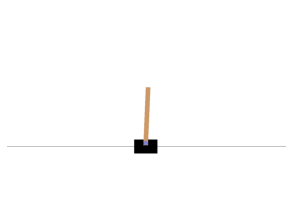

In [31]:
plot_environment(env)
plt.show()

Let's see how to interact with an environment. Your agent will need to select an action from an "action space" (the set of possible actions). Let's see what this environment's action space looks like:

In [20]:
env.action_space

Discrete(2)

Yep, just two possible actions: accelerate towards the left or towards the right.

Since the pole is leaning toward the right (`obs[2] > 0`), let's accelerate the cart toward the right:

![Neuron inner working](images/Figure_18_4.png)

In [32]:
action = 1  # accelerate right
obs, reward, done, info = env.step(action)
obs

array([-0.01261699,  0.19292789,  0.04204097, -0.28092127])

Notice that the cart is now moving toward the right (`obs[1] > 0`). The pole is still tilted toward the right (`obs[2] > 0`), but its angular velocity is now negative (`obs[3] < 0`), so it will likely be tilted toward the left after the next step.

Saving figure cart_pole_plot


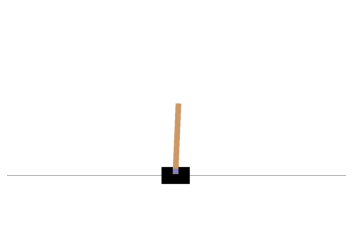

In [33]:
plot_environment(env)
save_fig("cart_pole_plot")

Looks like it's doing what we're telling it to do!

The environment also tells the agent how much reward it got during the last step:

In [21]:
reward

1.0

When the game is over, the environment returns `done=True`:

In [34]:
done

False

Finally, `info` is an environment-specific dictionary that can provide some extra information that you may find useful for debugging or for training. For example, in some games it may indicate how many lives the agent has.

In [121]:
info

{}

The sequence of steps between the moment the environment is reset until it is done is called an "episode". At the end of an episode (i.e., when `step()` returns `done=True`), you should reset the environment before you continue to use it.

In [122]:
if done:
    obs = env.reset()

Now how can we make the poll remain upright? We will need to define a _policy_ for that. This is the strategy that the agent will use to select an action at each step. It can use all the past actions and observations to decide what to do.

# A simple hard-coded policy

Let's hard code a simple strategy: if the pole is tilting to the left, then push the cart to the left, and _vice versa_. Let's see if that works:

In [35]:
env.seed(42)
# function that the action
def basic_policy(obs):
    angle = obs[2]
    # if the tilt is leftward, move left, if the tile is rightward move right
    return 0 if angle < 0 else 1
# count steps
totals = []
# run for 500 experiments
for episode in range(500):
    episode_rewards = 0
    # record observations
    obs = env.reset()
    # Run each experiment for 200 steps
    for step in range(200):
        # calculate action given the chosen policy
        action = basic_policy(obs)
        # calculation new position/rewards after the action was taken
        obs, reward, done, info = env.step(action)
        # add rewards to the counter
        episode_rewards += reward
        if done:
            break
    # append statistics of an experiment to the array
    totals.append(episode_rewards)

In [36]:
# calcualte averages
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(41.718, 8.858356280936096, 24.0, 68.0)

Well, as expected, this strategy is a bit too basic: the best it did was to keep the poll up for only 68 steps, with average 41 steps. This environment is considered solved when the agent keeps the poll up for 200 steps.

Let's visualize one episode:

In [37]:
env.seed(42)
# array of frames to plot. 
frames = []
# reset enviroment
obs = env.reset()
for step in range(200):
    # convert image to the rgb array
    img = env.render(mode="rgb_array")
    # append frame
    frames.append(img)
    # take action accoriding to policy
    action = basic_policy(obs)
    # get the new enviroment information
    obs, reward, done, info = env.step(action)
    if done:
        break

Now show the animation:

In [38]:
# animation and update
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

Clearly the system is unstable and after just a few wobbles, the pole ends up too tilted: game over. We will need to be smarter than that!

# Neural Network Policies

Neural network that will take observations as inputs, and output the action to take for each observation. 

To choose an action, the network will estimate a probability for each action, then we will select an action randomly according to the estimated probabilities.

In the case of the Cart-Pole environment actions are: left or right, so we only need one output neuron: it will output the probability `p` of the action 0 (left), and of course the probability of action 1 (right) will be `1 - p`. It will output the probability
p of action 0 (left), and of course the probability of action 1 (right) will be 1 – p.
For example, if it outputs 0.7, then we will pick action 0 with 70% probability, or
action 1 with 30% probability.



![Neuron inner working](images/Figure_18_5.png)

In [40]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

n_inputs = 4 # == env.observation_space.shape[0]

model = keras.models.Sequential([
    # 5 neurons in the hiddel layer
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    # predict probability, so the activation is a sigmoid.
    keras.layers.Dense(1, activation="sigmoid"),
])

* We can ignore past actions
* For example, if the environment only revealed the position of the cart but not its velocity, you would have to consider not only the current observation but also the previous observation in order to estimate the current velocity.
* Another example is if the observations are noisy: you may want to use the past few observations to estimate the most likely current state. 

Why pick random action instead of the highest probability one?
* Balance between exploring (accumulative knowledge) and exploting existing knowledge
* Trying new dishes in a restuarant even if you like one dish already. 

Let's write a small function that will run the model to play one episode, and return the frames so we can display an animation:

In [41]:
# visual function, optional
def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1")
    env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames

Now let's look at how well this randomly initialized policy network performs:

In [42]:
frames = render_policy_net(model)
plot_animation(frames)

Yeah... pretty bad. The neural network was not trained and  will have to learn to do better.

First let's see if it is capable of learning the basic policy we used earlier: go left if the pole is tilting left, and go right if it is tilting right.

We can make the same net play in 50 different environments in parallel (this will give us a diverse training batch at each step), and train for 5000 iterations. We also reset environments when they are done. We train the model using a custom training loop so we can easily use the predictions at each training step to advance the environments.

In [43]:
n_environments = 50
n_iterations = 5000
# get 50 random starting cart pole enviroments
envs = [gym.make("CartPole-v1") for _ in range(n_environments)]
# get distinct random seed index for each enviroment 
for index, env in enumerate(envs):
    env.seed(index)
np.random.seed(42)
# get observations array for 50 enviroments
observations = [env.reset() for env in envs]
optimizer = keras.optimizers.RMSprop()
# binary accuracy: policy action vs predicted action
loss_fn = keras.losses.binary_crossentropy

for iteration in range(n_iterations):
    # if angle < 0, we want proba(left) = 1., or else proba(left) = 0.
    target_probas = np.array([([1.] if obs[2] < 0 else [0.])
                              for obs in observations])
    # GradientTape computes the gradient of a computation with respect
    #to some inputs (deriviative)
    with tf.GradientTape() as tape:
        # calculated predicted probabilities
        left_probas = model(np.array(observations))
        # Loss function
        loss = tf.reduce_mean(loss_fn(target_probas, left_probas))
    print("\rIteration: {}, Loss: {:.3f}".format(iteration, loss.numpy()), end="")
    # take deriviative of the loss function with respect to trainable variables: 
    #[all weights and biases]
    grads = tape.gradient(loss, model.trainable_variables)
    # replace gradients and updated weights in the neural network
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    # get new actions. If 50 random numbers greater than model predictions, 
    #then action True. The higher left_probas, the more likely False -> move left, action =0
    # This is a random draw from the specified probabilities
    actions = (np.random.rand(n_environments, 1) > left_probas.numpy()).astype(np.int32)
    for env_index, env in enumerate(envs):
        # run actions and save new enviroment
        obs, reward, done, info = env.step(actions[env_index][0])
        # save new observations. If the pole fell (Done), then reset
        observations[env_index] = obs if not done else env.reset()

for env in envs:
    env.close()

Iteration: 4999, Loss: 0.094

In [44]:
frames = render_policy_net(model)
plot_animation(frames)

Looks like it learned the policy correctly. Now let's see if it can learn a better policy on its own. One that does not wobble as much.

#Evaluating Actions: The Credit Assignment Problem

* We don't know the optimal action at each step, so we cannot train the NN for it.
* In RL you observe final outcome -- result of many past actions. We don't know which one were correct.
* One solution: Value of of an action equals to the sum of discoutned rewards after it. Use discount factor $0<\gamma < 1$
![Neuron inner working](images/Figure_18_6.png)

* Assuming $\gamma = 0.8$ action of going right 3 times gets: $10 + \gamma * 0 + \gamma ^2 * (-50) = -22$. 
* Discount factor links past actions with future rewards. Large $\gamma$ -> more connection with future. Typical $0.90>\gamma>0.9$. For $\gamma = 0.95$ the rewards 13 steps into the future count roughly for half of current rewards.
* A good action can be followed by bad actions reducing it's observed rewards, but if we run experiments enough times these effects of bad and good future choices will be cancelled out when evaluation a particular action.  

# Policy Gradients

The _Policy Gradients_ algorithm assigns discounted future awards to the actions. 

1. First run network several times to maximize prob of chosen action, but don't apply gradients yet.
2. Once we run several games, compute the gradient score of each action using discounted awards
3. Positive gradient is good, negative it's bad
4. Compute mean of gradient vectors resulting and perform Gradient descent

Let's start by creating a function to play a single step using the model. We will also pretend for now that whatever action it takes is the right one, so we can compute the loss and its gradients (we will just save these gradients for now, and modify them later depending on how good or bad the action turned out to be):

In [47]:
# Here we are in step 1  and we will pretend that whatever action we take is correct.
def play_one_step(env, obs, model, loss_fn):
    #tf function to calculate gradients
    with tf.GradientTape() as tape:
        # get predicted probabilities of left action
        left_proba = model(obs[np.newaxis])
        # if the action if higher the left_prage, move right (1-p)
        action = (tf.random.uniform([1, 1]) > left_proba)
#If the action is 0 (left), then the target probability of going left will be
#1. If the action is 1 (right), then the target probability will be 0.
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        # Loss is the difference between the action and the probability
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    # calculate gradients 
    grads = tape.gradient(loss, model.trainable_variables)
    # make and action and get new enviroment
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    # return results
    return obs, reward, done, grads

If `left_proba` is high, then `action` will most likely be `False` (since a random number uniformally sampled between 0 and 1 will probably not be greater than `left_proba`). And `False` means 0 when you cast it to a number, so `y_target` would be equal to 1 - 0 = 1. In other words, we set the target to 1, meaning we pretend that the probability of going left should have been 100% (so we took the right action).

Now let's create another function that will rely on the `play_one_step()` function to play multiple episodes, returning all the rewards and gradients, for each episode and each step:

In [48]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    # setup list of rewards and gradients 
    all_rewards = []
    all_grads = []
    # loop over episodes (experiments)
    for episode in range(n_episodes):
        # setup a list of rewards and gradients for current step
        current_rewards = []
        current_grads = []
        # reset enviroment
        obs = env.reset()
        # loop over steps for each episode
        for step in range(n_max_steps):
            # run function play_one step defined above
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            # save rewards and gradients
            current_rewards.append(reward)
            current_grads.append(grads)
            # stop loop if the pole fell
            if done:
                break
        # append rewards for the episode
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

The Policy Gradients algorithm uses the model to play the episode several times (e.g., 10 times), then it goes back and looks at all the rewards, discounts them and normalizes them. So let's create couple functions for that: the first will compute discounted rewards; the second will normalize the discounted rewards across many episodes.

In [49]:
# set up function to discount rewards
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    # step backward disounting each step. The last step is not discounted.
    for step in range(len(rewards) - 2, -1, -1):
        # discount step. Step n-1 will be discounted once, step n-2 twice, etc.
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    # discount all rewards
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    # concatenate rewards from all episodes and steps
    flat_rewards = np.concatenate(all_discounted_rewards)
    # make the rewards standard normal dist
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

Say there were 3 actions, and after each action there was a reward: first 10, then 0, then -50. If we use a discount factor of 80%, then the 3rd action will get -50 (full credit for the last reward), but the 2nd action will only get -40 (80% credit for the last reward), and the 1st action will get 80% of -40 (-32) plus full credit for the first reward (+10), which leads to a discounted reward of -22:

In [50]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22, -40, -50])

To normalize all discounted rewards across all episodes, we compute the mean and standard deviation of all the discounted rewards, and we subtract the mean from each discounted reward, and divide by the standard deviation:

In [51]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

The first episode was much worse than the second, so its normalized advantages are
all negative; all actions from the first episode would be considered bad.

Conversely all actions from the second episode would be considered good.

In [52]:
# 150 training iterations, 10 episodes per iteration. Each episode can last 200 steps.
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

In [53]:
optimizer = keras.optimizers.Adam(lr=0.01)
# binary classifier
loss_fn = keras.losses.binary_crossentropy

In [54]:
# the model is almost identical to the one we used before
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[4]),
    keras.layers.Dense(1, activation="sigmoid"),
])

In [55]:
env = gym.make("CartPole-v1")
env.seed(42);
# loop through the iterations
for iteration in range(n_iterations):
    # play 10 episodes per iterations
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    # total rewards per iteration
    total_rewards = sum(map(sum, all_rewards))                     # Not shown in the book
    # pring aveage number of rewards per update
    print("\rIteration: {}, mean rewards: {:.1f}".format(          # Not shown
        iteration, total_rewards / n_episodes_per_update), end="") # Not shown
    # discount and normilized awards from the iteration
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)
    all_mean_grads = []
    # loop over model parameters (weights and biases)
    for var_index in range(len(model.trainable_variables)):
        # get average gradient weighted by the average reward, so that succeefull grad will have 
        # larger weight
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             # final rewards in all steps in all episodes
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        #append average gradients for the iteration.
        all_mean_grads.append(mean_grads)
        # apply updated gradiatent to the model.
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()

Iteration: 149, mean rewards: 175.6

This results is considerably better than the average rewards of 41, which we got with the hard-coded policy.

In [56]:
frames = render_policy_net(model)
plot_animation(frames)

The simple policy gradients algorithm we used for CartPole task would not scale well to larger and more complex tasks. We have to play this game long-time before we will see the advantage of each action. There are some more efficient solutions such as Actor-Critic algorithms. 

Next we will apporach policy from another Angle. 

Whereas PG algorithms directly try to optimize the policy to increase rewards, the algorithms we will look at
now are less direct: the agent learns to estimate the expected return for each state, or
for each action in each state, then it uses this knowledge to decide how to act. 

# Markov Chains

* Andrey Markov studied stochastic processes with no memory, called Markov chains.

Such a process has a fixed number of states, and it randomly evolves from one state to another at each step. The probability for it to evolve from a state s to a state s′ is fixed, and it depends only on the pair ($s$, $s
′$), not on past states (no memory).

![Neuron inner working](images/Figure_18_7.png)
* $s_3$ is the terminal state

In [57]:
np.random.seed(42)
# based on the picture above
transition_probabilities = [ # shape=[s, s']
        [0.7, 0.2, 0.0, 0.1],  # from s0 to s0, s1, s2, s3
        [0.0, 0.0, 0.9, 0.1],  # from s1 to ...
        [0.0, 1.0, 0.0, 0.0],  # from s2 to ...
        [0.0, 0.0, 0.0, 1.0]]  # from s3 to ...

n_max_steps = 50

def print_sequence():
    current_state = 0
    print("States:", end=" ")
    for step in range(n_max_steps):
        print(current_state, end=" ")
        if current_state == 3:
            break
        current_state = np.random.choice(range(4), p=transition_probabilities[current_state])
    else:
        print("...", end="")
    print()

for _ in range(10):
    print_sequence()

States: 0 0 3 
States: 0 1 2 1 2 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 ...
States: 0 0 3 
States: 0 0 0 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 



Richard Bellman in 1950s described Markov Processes -- Markov Chains where at each state an agent can choose and action, which would lead to a new state and new reward with some probability. 

![Neuron inner working](images/Figure_18_8.png)

The agent starts at state $s_0$, the agent can choose between actions a0, a1, or a2.

In state $s_0$ it is clear that action $a_0$ is the best option, and in state $s_2$ the agent has no choice but to take action $a_1$, but in state $s_1$ it is not obvious whether the agent should stay put ($a_0$) or go through the fire ($a_2$).


# Markov Decision Process

Let's define some transition probabilities, rewards and possible actions. For example, in state s0, if action a0 is chosen then with proba 0.7 we will go to state s0 with reward +10, with probability 0.3 we will go to state s1 with no reward, and with never go to state s2 (so the transition probabilities are `[0.7, 0.3, 0.0]`, and the rewards are `[+10, 0, 0]`):

In [58]:
transition_probabilities = [ # shape=[s, a, s']
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
        [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
        [None, [0.8, 0.1, 0.1], None]]
rewards = [ # shape=[s, a, s']
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
        [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]]
possible_actions = [[0, 1, 2], [0, 2], [1]]

# Q-Value Iteration

Bellman estimate optimal state value by using sum of future discounted rewards assuming a player will act optimally:
\begin{equation}
V*(s) = \max_{a}\sum_{s} T(s,a,s')[R(s,a,s') + \gamma * V(s')] \; \text{for all s}
\end{equation}
In this equation:
• $T(s, a, s′)$ is the transition probability from state $s$ to state $s′$, given that the agent
chose action a. For example, T(s2, a1, s0) = 0.8.
• $R(s, a, s′)$ is the reward that the agent gets when it goes from state $s$ to state $s′$,
given that the agent chose action $a$. For example, $(s2, a1, s0) = +40$.
• $\gamma$ is the discount factor.


This equation leads directly to an algorithm that can estimates the optimal
state value of every possible state:
- first initialize all the state value estimates to zero
- iteratively update them using the Value Iteration algorithm.
\begin{equation}
V_{k+1}(s) = \max_{a}\sum_{s'} T(s,a,s')[R(s,a,s') + \gamma * V_{k}(s')] \; \text{for all s}
\end{equation}
where $V_{k}*(s')$ is the $k^{th}$ iteration of the algorithm.

Given enough time, these estimates are guaranteed to converge to the optimal state values, corresponding to the optimal policy. 

Knowing the optimal state values is useful, but it does not give us the optimal policy for the agent.

Another Bellman algorithm finds optimal state-action values, generally called $Q-Values$.
(Quality Values).

The optimal $Q-Value$ of the state-action pair $(s, a)$ is $Q^{*}(s, a)$ -- the sum of discounted future rewards the agent can expect on average after it reaches the state s and chooses action a, assuming it acts optimally after that action.

Once again, we initialize all the $Q-Value$ estimates to zero, then you update them using the Q-Value Iteration algorithm:

\begin{equation}
Q_{k+1}(s,a) = \sum_{s'} T(s,a,s')[R(s,a,s') + \gamma * Q_{k}*(s',a')] \; \text{for all} \; s', a
\end{equation}

Once you have the optimal Q-Values, then the optimal polic noted  $\pi^{*}(s)$ is just the choice of the highest Q-Value in each state: $\pi^{*}(s)= argmax\: Q^{*}(s,a)$


In [60]:
Q_values = np.full((3, 3), -np.inf) # -np.inf for impossible actions
# for possible actions set Q-value at zero
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all possible actions

In [62]:
gamma = 0.90  # the discount factor

history1 = [] # Not shown in the book (for the figure below)
# iterate over 50 steps
for iteration in range(50):
    # save old Q_value
    Q_prev = Q_values.copy()
    #append the history of Q-values
    history1.append(Q_prev) # Not shown
    # loop over 3 states
    for s in range(3):
        # loop over possible actions
        for a in possible_actions[s]:
            # value of choosing action a in state s
            Q_values[s, a] = np.sum([
                    # expected rewards
                    transition_probabilities[s][a][sp]
                #based on the choosing actions with highest Q-value. (based on last step Q-values)
                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)])
# history of Q-values
history1 = np.array(history1) # Not shown

In [63]:
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

when the agent is in state $s_0$ and it chooses action $a_1$, the expected sum
of discounted future rewards is approximately 17.0.

The optimal policy for this MDP, when using a discount factor of 0.90, is to choose action a0 when in state s0, and choose action a0 when in state s1, and finally choose action a1 (the only possible action) when in state s2.

In [64]:
# plot evolution in Q-valus
np.argmax(Q_values, axis=1)
array1 = []
array2 = []
array3 = []
for i in range(0,50):
    array1.append(history1[i][0][0])
    array2.append(history1[i][0][1])
    array3.append(history1[i][0][2])


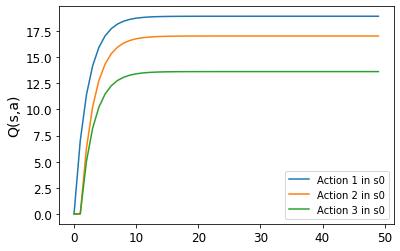

In [65]:
import matplotlib.pyplot as plt
plt.plot(array1, label='Action 1 in s0')
plt.plot(array2, label='Action 2 in s0')
plt.plot(array3, label='Action 3 in s0')
plt.ylabel('Q(s,a)')
plt.legend()
# We figured out the right action quickly

Let's try again with a discount factor of 0.95:

In [66]:
Q_values = np.full((3, 3), -np.inf) # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all possible actions

In [67]:
gamma = 0.95  # the discount factor

for iteration in range(50):
    Q_prev = Q_values.copy()
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)])

In [68]:
Q_values

array([[21.73304188, 20.63807938, 16.70138772],
       [ 0.95462106,        -inf,  1.01361207],
       [       -inf, 53.70728682,        -inf]])

In [69]:
np.argmax(Q_values, axis=1)

array([0, 2, 1])

Now the policy has changed! In state s1, we now prefer to go through the fire (choose action a2). This is because the discount factor is larger so the agent values the future more, and it is therefore ready to pay an immediate penalty in order to get more future rewards.

# Temporal Difference in Learning

Reinforcement Learning problems with discrete actions can often be modeled as
Markov decision processes.

The problem is that the agent initially has no idea what the transition
probabilities $T$ and it does not know what the rewards are going to be either $R$.

It must experience each state and each transition at least once to know the rewards, and it must experience them multiple times if it is to have a reasonable estimate of the transition probabilities.

The Temporal Difference Learning (TD Learning) algorithm is the Q-Values tweaked to take into account the fact that the agent has little knowledge of the MDP. 

We assume that the agent initially knows only the possible states and actions, and nothing more. 

The agent uses an exploration policy—for example, a purely random policy—to explore the MDP, and as it progresses, the TD Learning algorithm updates the estimates of the state values based on the transitions and rewards that are actually observed.

TD Learning Algorithm
\begin{equation}
V_{k+1} \leftarrow (1-\alpha) V_{k}(s) + \alpha(r + \gamma * V_{k} (s'))
\end{equation}
or equivalently
\begin{equation}
V_{k+1} \leftarrow V_{k}(s) + \alpha * \lambda_{k}(s,r,s')
\end{equation}
with  $\lambda_{k}(s,r,s') = r + \gamma * V_{k}(s') - V_{k}(s)$
In the equation:
* $\alpha$ is the learning rate (e.g. 0.01) when we learn rewards and transitions probabilities
* $r + \gamma * V_{k}(s')$ is the TD target, what we want to learn. 
*  $\lambda_{k}(s,r,s')$ is the TD error, new information we learnt in the step $k+1$.

A more consise notation would be how we update out expectation of $a$ from the new information obtained $b$ through the learning rate $\alpha$:

$a \underset{\alpha}{\leftarrow } b = a_{k+1} \leftarrow (1- \alpha) * a_k + \alpha * b$ then we can rewrite:

$V(s) \underset{\alpha}{\leftarrow } r + \gamma * V(s')$




For each state $s$, this algorithm keeps track of a running average of the immediate
rewards the agent gets upon leaving that state, plus the rewards it expects to get
later

# Q-Learning



Q-Learning works by watching an agent play (e.g., randomly) and gradually improving its estimates of the Q-Values. Once it has accurate Q-Value estimates (or close enough), then the optimal policy consists in choosing the action that has the highest Q-Value (i.e., the greedy policy).

\begin{equation}
Q(s,a) \underset{\alpha}{\leftarrow } r + \gamma \underset{a'}{\max} Q(s',a')
\end{equation}

For each state-action pair $(s, a)$ we track of a running average of the
rewards $r$ the agent gets upon leaving the state $s$ with action $a$, plus the sum of discounted
future rewards it expects to get. 

To estimate this sum, we take the maximum of the Q-Value estimates for the next state $s′$, since we assume that the target policy would act optimally from then on.


We will need to simulate an agent moving around in the environment, so let's define a function to perform some action and get the new state and a reward:

In [70]:
# expoloration function. 
def step(state, action):
    # get transitional probability to the next state after the action is taken
    probas = transition_probabilities[state][action]
    #Find randomly next state according to defined probabilities
    next_state = np.random.choice([0, 1, 2], p=probas)
    # get the reward of the next state
    reward = rewards[state][action][next_state]
    # return next state and reward
    return next_state, reward

We also need an exploration policy, which can be any policy, as long as it visits every possible state many times. We will just use a random policy, since the state space is very small:

In [71]:
# randomly choose a possible action available in this state
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

Now let's initialize the Q-Values like earlier, and run the Q-Learning algorithm:

In [72]:
np.random.seed(42)
# start with negative inf values for Q(s,a)
Q_values = np.full((3, 3), -np.inf)
# for possible actions set Q(s,a)= 0
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0

alpha0 = 0.05 # initial learning rate
decay = 0.005 # learning rate decay
gamma = 0.90 # discount factor
state = 0 # initial state
history2 = [] # Save history of Q-values learning
# interation over steps to learn Q-values
for iteration in range(10000):
    history2.append(Q_values.copy()) # append each step to history
    action = exploration_policy(state) # take random action to explore space
    next_state, reward = step(state, action) # get next state action and the reward
    next_value = np.max(Q_values[next_state]) # greedy policy at the next step, choose highest Q-value
    alpha = alpha0 / (1 + iteration * decay) # decay learning rate
    Q_values[state, action] *= 1 - alpha # The share of the updated Q-value
    Q_values[state, action] += alpha * (reward + gamma * next_value) # add new learnt information to the Q-value
    state = next_state

history2 = np.array(history2) # add to history of Q-values

In [73]:
Q_values

array([[18.77621289, 17.2238872 , 13.74543343],
       [ 0.        ,        -inf, -8.00485647],
       [       -inf, 49.40208921,        -inf]])

In [74]:
np.argmax(Q_values, axis=1) # optimal action for each state

array([0, 0, 1])

Saving figure q_value_plot


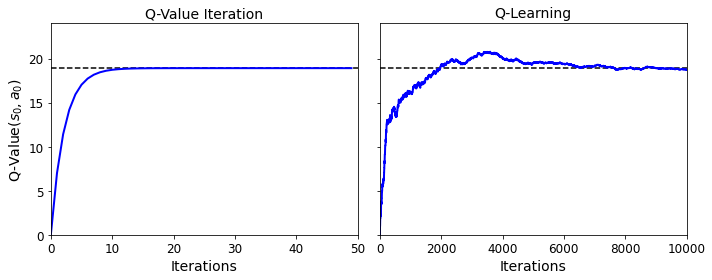

In [75]:
# Plot histroy of learning Q(s0,a0)
true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])

save_fig("q_value_plot")

Q-learning converges to the optimal Q-Values, but it will take too long and too much hyperparameter tuning.

Q-Value Iteration algorithm (left) converges very quickly, in fewer than 20 iterations, Q-Learning takes 8,000 iterations. Not knowing the transition probabilities or the rewards makes finding the optimal policy significantly harder!

The problem with Q-learning is that is tries to learn about the enviroment and optimize the policy in the same time, which is very hard. Can we do better?

# Exploration Policies

Q-Learning can work only if the exploration policy fully explores the MDP. A fully random policy will eventually explore all options, but a better is $\epsilon$-greedy policy:
- randomly explore with the probability $\epsilon$
-  with probability $1–ε$ explore/choose actions with the highest Q-values, so we explore more valuable paths. Importatn for a large choice sets.

Usually start with large $\epsilon$ close to 1, and gradually reduce it to move from exploration to the optimal path search. 

Alternative to this strategy is to explore paths that has not been tried before. 

# Approximate Q-Learning and Deep Q-Learning

Q-Learning does not scale for the enviroments with the large action space, like Pac-Man: 150 pellets to eat and 8 actions to choose. The number of states is $2^{150} \approx 1045$. The number of states with different combinations for the possible positions of ghosts makes the total number larger than the number of atoms on Earth.

The solution the function $Q_{\theta}(s,a)$ that approximates Q-Value of the pair $(s,a)$ under some small number of parameters $\theta$. DNN can estimate Q-Values in Deep Q-Network (DQN).


The Q-value should approximate the reward $r$ under $(s,a)$ plus the discounted value of playing optimally from then on. DQN estimates this sum a Q-Values at $(s',a')$ for all possible actions $a'$. Then we pick the best $a'$ and use it to value to calculated the discounted $Q(s',a')$:

\begin{equation}
Q_{target}(s,a) = r + \gamma * \underset{a'}{\max} Q_{\theta}(s',a')
\end{equation}

With this target Q-Value, we can run a train out network using Gradient Descent algorithm to minimize the squared error between the estimated Q-Value $Q(s, a)$ and the target Q-Value.

Let's build the DQN. Given a state, it will estimate, for each possible action, the sum of discounted future rewards it can expect after it plays that action (but before it sees its outcome):

In [77]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

env = gym.make("CartPole-v1")
input_shape = [4] # == env.observation_space.shape
n_outputs = 2 # We extimate Q-Values for going left or right at each step.
# simple NN
model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

To select an action using this DQN, we just pick the action with the largest predicted Q-value. However, to ensure that the agent explores the environment, we choose a random action with probability `epsilon`.

In [86]:
# Epsilon-greedy policy. 
def epsilon_greedy_policy(state, epsilon=0):
    # randomly choose exploration
    if np.random.rand() < epsilon:
        return np.random.randint(2) # randomly choose 0 or 1
    else:
        # randomly choose max Q-value
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

We will also need a replay memory. It will contain the agent's experiences, in the form of tuples: `(obs, action, reward, next_obs, done)`. We can use the `deque` class for that:

In [87]:
# A fast list of elements connected to immediate neighbors
from collections import deque
# Store all experience in this memory list. We will sample from it using training.
replay_memory = deque(maxlen=2000)

And let's create a function to sample experiences from the replay memory. It will return 5 NumPy arrays: `[obs, actions, rewards, next_obs, dones]`.

In [88]:
# get a sample of experiences (situations)
def sample_experiences(batch_size):
    # random indexes from the experience buffer
    indices = np.random.randint(len(replay_memory), size=batch_size)
    #draw batch_size number of random experiences
    batch = [replay_memory[index] for index in indices]
    # get information from these experiences. 
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    # return information 
    return states, actions, rewards, next_states, dones

Now we can create a function that will use the DQN to play one step, and record its experience in the replay memory:

In [89]:
def play_one_step(env, state, epsilon):
    # chosen action
    action = epsilon_greedy_policy(state, epsilon)
    # find the next state and reward from the chosen action
    next_state, reward, done, info = env.step(action)
    # add the action, results and experience in one array
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

Lastly, let's create a function that will sample some experiences from the replay memory and perform a training step:

**Note**: the first 3 releases of the 2nd edition were missing the `reshape()` operation which converts `target_Q_values` to a column vector (this is required by the `loss_fn()`).

In [90]:
batch_size = 32
discount_rate = 0.95 # gamma
optimizer = keras.optimizers.Adam(lr=1e-3)
loss_fn = keras.losses.mean_squared_error # MSE because Q-Values are numbers

def training_step(batch_size):
    experiences = sample_experiences(batch_size)  # get experiences 
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states) #predict Q-values of available actions
    max_next_Q_values = np.max(next_Q_values, axis=1) # choose the best action
    # Target Q-value: reward + discounted Q-value of the best action
    target_Q_values = (rewards +
                       # add discounted Q-value is this is not the last step
                       (1 - dones) * discount_rate * max_next_Q_values) 
    # Q-values of the two actions available
    target_Q_values = target_Q_values.reshape(-1, 1)
    # add zeros to account for the actions not takes: actions 1,1,0 becomes maskes [[0,1], [0,1], [0,1]],
    # we can multiply this vector of maked actions by gradients or Q-values, getting zeros for the Q-values
    # we don't want.
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        # get predicted Q-Values from the model
        all_Q_values = model(states)
        # get the Q-Values fro the chosen actions
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        # calculate loss between predicted Q-values and experienced state-action pairs.
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

And now, let's train the model!

In [91]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = [] 
best_score = 0

In [92]:
# Run 600 episodes (games), with 200 steps in each episodes.
for episode in range(600):
    obs = env.reset()  
    for step in range(200): # loop over the steps
        epsilon = max(1 - episode / 500, 0.01) # reduce exploration for later episodes
        obs, reward, done, info = play_one_step(env, obs, epsilon) # get enviroment variables
        if done:
            break
    rewards.append(step) # append rewards (number of turns survived) for the episode
    if step > best_score: # If the rewards are the best in history, update weights 
        best_weights = model.get_weights() #  save best weights
        best_score = step # best score
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="") # Not shown
    if episode > 50:# there is not training for the first 50 episodes, we want the buffer to fill-up, we are still
        # learning about the enviroment.
        training_step(batch_size)

model.set_weights(best_weights)

Episode: 599, Steps: 19, eps: 0.0108

Saving figure dqn_rewards_plot


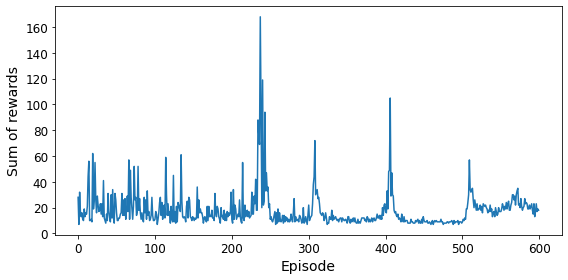

In [93]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
save_fig("dqn_rewards_plot")
plt.show()

There was no progress for 300 episodes, the we suddely were able to finish the game with 200 (max score) and quickly lost our progress.

We experienced catastrophic forgetting -- a common problem for RL. SGD has a short memory and the expiences may change. We can try to fix it by increasing the size of the replay buffer or reducing the learning rate. 

Generally, RL is hard and fragile: 
As the researcher Andrej Karpathy put it: “Supervised learning wants to work. […] RL must be forced to work.”

This is the main reason RL is not widely adopted yet relative to DL. 

We did not plot loss because it is not really relevant to the task. A loss can go down from overfitting, we can predict Q-Values very well, but the pole will still fall. 

In [94]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

Not bad at all!

## Online Model

In the basic Deep Q-Learning algorithm, the model is used both to make predictions
and to set its own targets. This may create unstable feedback loop.


DeepMind researchers proposed using two DQNs instead of one: the first is the online model, which learns at each
step and is used to move the agent around, and the other is the target model used only
to define the targets. 

The target model is just a clone of the online model. Then, in the training_step() function, we use the
target model instead of the online model when computing the Q-Values of the next states. Finally, in the training loop, we must copy the weights of the online model to the target
model, at regular intervals (e.g., every 50 episodes).

Since the target model is updated much less often than the online model, the Q-Value
targets are more stable.


## Double DQN

DeepMind researchers tweaked their DQN algorithm, increasing its performance and stabilizing training.

They called this variant Double DQN. The update was based on the observation that the target network is prone to
overestimating Q-Values. If all actions are equally good, but one just randomly looks better, DQN would greatly overcluse this action, which looks good by pure chance. 

We fix this by using the online model instead of the target model when selecting the best
actions for the next states, and using the target model only to estimate the Q-Values
for these best actions. 

In [95]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
# build out regular model for online training
model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=[4]),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])
# copy the model and call it target
target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [97]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(lr=1e-3)
loss_fn = keras.losses.Huber()
# The training step is the same as before
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)        # online model
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards + 
                       (1 - dones) * discount_rate * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)        # online model
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [98]:
# save get buffer
replay_memory = deque(maxlen=2000)

In [99]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0

for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step > best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
    if episode > 50:
        training_step(batch_size)
        # every 50 copy weights to the target model
    if episode % 50 == 0:
        target.set_weights(model.get_weights())
    # Alternatively, you can do soft updates at each step:
    #if episode > 50:
        #target_weights = target.get_weights()
        #online_weights = model.get_weights()
        #for index in range(len(target_weights)):
        #    target_weights[index] = 0.99 * target_weights[index] + 0.01 * online_weights[index]
        #target.set_weights(target_weights)

model.set_weights(best_weights)

Episode: 599, Steps: 49, eps: 0.0100

Saving figure double_dqn_rewards_plot


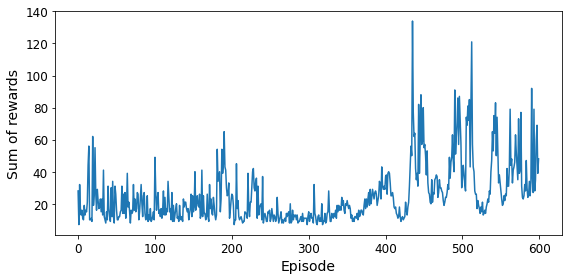

In [100]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
save_fig("double_dqn_rewards_plot")
plt.show()

In [101]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

# Dueling Double DQN

Deepmind introduced another important model: dueling DQN algorithm (DDQN) was introduced. First
note that the Q-Value of a state-action pair: <br>
$Q(s, a)$ = $V(s) + A(s, a)$
, where $V(s)$ is the value of state $s$ and $A(s, a)$ is the advantage of taking the action $a$ in state $s$, compared to all other possible actions in that state. <br>


Moreover, the value of a state is equal to the Q-Value of the best action $a*$ for that state (since we
assume the optimal policy will pick the best action), so <br>
$V(s) = Q(s, a*)$, which implies that A(s, a*) = 0.

In a Dueling DQN, the model estimates both the value of the state and the advantage of each possible action.
Since the best action should have an advantage of 0, the model subtracts the maximum predicted advantage from all pre‐
dicted advantages. 


In [102]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
input_states = keras.layers.Input(shape=[4])
hidden1 = keras.layers.Dense(32, activation="elu")(input_states)
hidden2 = keras.layers.Dense(32, activation="elu")(hidden1)
state_values = keras.layers.Dense(1)(hidden2) # value of the state
raw_advantages = keras.layers.Dense(n_outputs)(hidden2) # raw values of the advantages for actions (2).
advantages = raw_advantages - K.max(raw_advantages, axis=1, keepdims=True)# Normlized best action at 0
Q_values = state_values + advantages # total values is the ouput
model = keras.models.Model(inputs=[input_states], outputs=[Q_values])
# copt weights for target model
target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [103]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(lr=1e-2)
loss_fn = keras.losses.Huber() # Huber loss function: quadratice for small values and linear for large values
#training function is the same as before
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards + 
                       (1 - dones) * discount_rate * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [104]:
replay_memory = deque(maxlen=2000)

In [105]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0

for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step > best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
    # We mix duelling and double DQN
    if episode > 50:
        training_step(batch_size)
    if episode % 200 == 0:
        target.set_weights(model.get_weights())

model.set_weights(best_weights)

Episode: 599, Steps: 74, eps: 0.0100

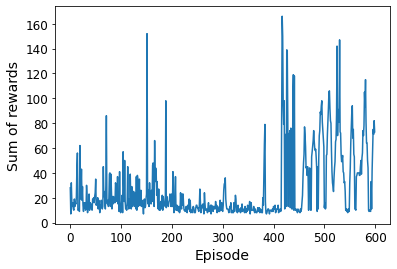

In [109]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Sum of rewards")
plt.show()

In [110]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

This looks like a pretty robust agent!

In [111]:
env.close()

# Using TF-Agents to Beat Breakout

Let's use TF-Agents to create an agent that will learn to play Breakout. We will use the Deep Q-Learning algorithm, so you can easily compare the components with the previous implementation, but TF-Agents implements many other (and more sophisticated) algorithms!

## TF-Agents Environments

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
from tf_agents.environments import suite_gym

env = suite_gym.load("Breakout-v4")
env

In [ ]:
env.gym

In [ ]:
env.seed(42)
env.reset()

TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
       

In [ ]:
env.step(1) # Fire

TimeStep(step_type=array(1, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
       

Saving figure breakout_plot


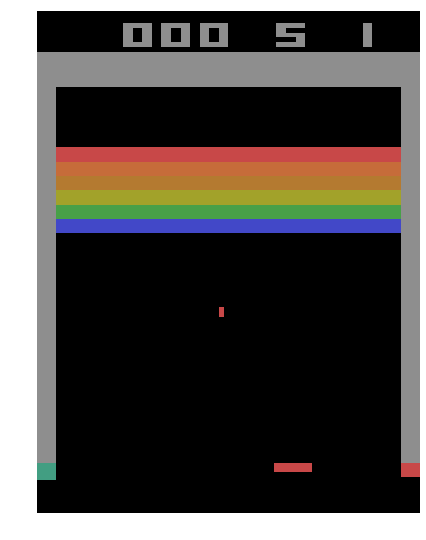

In [ ]:
img = env.render(mode="rgb_array")

plt.figure(figsize=(6, 8))
plt.imshow(img)
plt.axis("off")
save_fig("breakout_plot")
plt.show()

In [ ]:
env.current_time_step()

TimeStep(step_type=array(1, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
       

## Environment Specifications

In [ ]:
env.observation_spec()

BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('float32'), name=None, minimum=[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], maximum=[[[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 ...

 [[255. 255. 255

In [ ]:
env.action_spec()

BoundedArraySpec(shape=(), dtype=dtype('int64'), name=None, minimum=0, maximum=3)

In [ ]:
env.time_step_spec()

TimeStep(step_type=ArraySpec(shape=(), dtype=dtype('int32'), name='step_type'), reward=ArraySpec(shape=(), dtype=dtype('float32'), name='reward'), discount=BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0), observation=BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('float32'), name=None, minimum=[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], maximum=[[[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[

## Environment Wrappers

You can wrap a TF-Agents environments in a TF-Agents wrapper:

In [ ]:
from tf_agents.environments.wrappers import ActionRepeat

repeating_env = ActionRepeat(env, times=4)
repeating_env

In [ ]:
repeating_env.unwrapped

Here is the list of available wrappers:

In [ ]:
import tf_agents.environments.wrappers

for name in dir(tf_agents.environments.wrappers):
    obj = getattr(tf_agents.environments.wrappers, name)
    if hasattr(obj, "__base__") and issubclass(obj, tf_agents.environments.wrappers.PyEnvironmentBaseWrapper):
        print("{:27s} {}".format(name, obj.__doc__.split("\n")[0]))

ActionClipWrapper           Wraps an environment and clips actions to spec before applying.
ActionDiscretizeWrapper     Wraps an environment with continuous actions and discretizes them.
ActionOffsetWrapper         Offsets actions to be zero-based.
ActionRepeat                Repeates actions over n-steps while acummulating the received reward.
FlattenObservationsWrapper  Wraps an environment and flattens nested multi-dimensional observations.
GoalReplayEnvWrapper        Adds a goal to the observation, used for HER (Hindsight Experience Replay).
PyEnvironmentBaseWrapper    PyEnvironment wrapper forwards calls to the given environment.
RunStats                    Wrapper that accumulates run statistics as the environment iterates.
TimeLimit                   End episodes after specified number of steps.


The `suite_gym.load()` function can create an env and wrap it for you, both with TF-Agents environment wrappers and Gym environment wrappers (the latter are applied first).

In [ ]:
from functools import partial
from gym.wrappers import TimeLimit

limited_repeating_env = suite_gym.load(
    "Breakout-v4",
    gym_env_wrappers=[partial(TimeLimit, max_episode_steps=10000)],
    env_wrappers=[partial(ActionRepeat, times=4)],
)

In [ ]:
limited_repeating_env

Create an Atari Breakout environment, and wrap it to apply the default Atari preprocessing steps:

In [ ]:
limited_repeating_env.unwrapped

In [ ]:
from tf_agents.environments import suite_atari
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4

max_episode_steps = 27000 # <=> 108k ALE frames since 1 step = 4 frames
environment_name = "BreakoutNoFrameskip-v4"

env = suite_atari.load(
    environment_name,
    max_episode_steps=max_episode_steps,
    gym_env_wrappers=[AtariPreprocessing, FrameStack4])

In [ ]:
env

Play a few steps just to see what happens:

In [ ]:
env.seed(42)
env.reset()
time_step = env.step(1) # FIRE
for _ in range(4):
    time_step = env.step(3) # LEFT

In [ ]:
def plot_observation(obs):
    # Since there are only 3 color channels, you cannot display 4 frames
    # with one primary color per frame. So this code computes the delta between
    # the current frame and the mean of the other frames, and it adds this delta
    # to the red and blue channels to get a pink color for the current frame.
    obs = obs.astype(np.float32)
    img = obs[..., :3]
    current_frame_delta = np.maximum(obs[..., 3] - obs[..., :3].mean(axis=-1), 0.)
    img[..., 0] += current_frame_delta
    img[..., 2] += current_frame_delta
    img = np.clip(img / 150, 0, 1)
    plt.imshow(img)
    plt.axis("off")

Saving figure preprocessed_breakout_plot


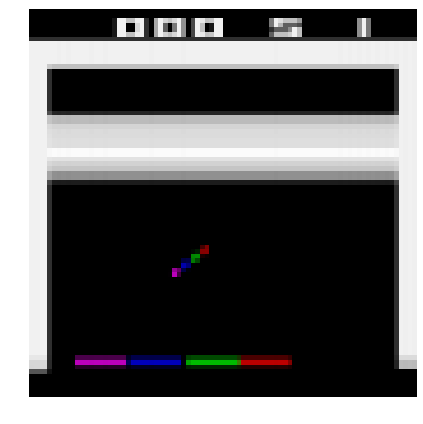

In [ ]:
plt.figure(figsize=(6, 6))
plot_observation(time_step.observation)
save_fig("preprocessed_breakout_plot")
plt.show()

Convert the Python environment to a TF environment:

In [ ]:
from tf_agents.environments.tf_py_environment import TFPyEnvironment

tf_env = TFPyEnvironment(env)

## Creating the DQN

Create a small class to normalize the observations. Images are stored using bytes from 0 to 255 to use less RAM, but we want to pass floats from 0.0 to 1.0 to the neural network:

Create the Q-Network:

In [ ]:
from tf_agents.networks.q_network import QNetwork

preprocessing_layer = keras.layers.Lambda(
                          lambda obs: tf.cast(obs, np.float32) / 255.)
conv_layer_params=[(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
fc_layer_params=[512]

q_net = QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    preprocessing_layers=preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params)

Create the DQN Agent:

In [ ]:
from tf_agents.agents.dqn.dqn_agent import DqnAgent

# see TF-agents issue #113
#optimizer = keras.optimizers.RMSprop(lr=2.5e-4, rho=0.95, momentum=0.0,
#                                     epsilon=0.00001, centered=True)

train_step = tf.Variable(0)
update_period = 4 # run a training step every 4 collect steps
optimizer = tf.compat.v1.train.RMSPropOptimizer(learning_rate=2.5e-4, decay=0.95, momentum=0.0,
                                     epsilon=0.00001, centered=True)
epsilon_fn = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0, # initial ε
    decay_steps=250000 // update_period, # <=> 1,000,000 ALE frames
    end_learning_rate=0.01) # final ε
agent = DqnAgent(tf_env.time_step_spec(),
                 tf_env.action_spec(),
                 q_network=q_net,
                 optimizer=optimizer,
                 target_update_period=2000, # <=> 32,000 ALE frames
                 td_errors_loss_fn=keras.losses.Huber(reduction="none"),
                 gamma=0.99, # discount factor
                 train_step_counter=train_step,
                 epsilon_greedy=lambda: epsilon_fn(train_step))
agent.initialize()

Create the replay buffer:

In [ ]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=1000000)

replay_buffer_observer = replay_buffer.add_batch

Create a simple custom observer that counts and displays the number of times it is called (except when it is passed a trajectory that represents the boundary between two episodes, as this does not count as a step):

In [ ]:
class ShowProgress:
    def __init__(self, total):
        self.counter = 0
        self.total = total
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")

Let's add some training metrics:

In [ ]:
from tf_agents.metrics import tf_metrics

train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric(),
]

In [ ]:
train_metrics[0].result()

<tf.Tensor: id=469, shape=(), dtype=int64, numpy=0>

In [ ]:
from tf_agents.eval.metric_utils import log_metrics
import logging
logging.getLogger().setLevel(logging.INFO)
log_metrics(train_metrics)

I0528 08:47:44.704986 140735810999168 metric_utils.py:47]  
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 0
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


Create the collect driver:

In [ ]:
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

collect_driver = DynamicStepDriver(
    tf_env,
    agent.collect_policy,
    observers=[replay_buffer_observer] + train_metrics,
    num_steps=update_period) # collect 4 steps for each training iteration

Collect the initial experiences, before training:

In [ ]:
from tf_agents.policies.random_tf_policy import RandomTFPolicy

initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(),
                                        tf_env.action_spec())
init_driver = DynamicStepDriver(
    tf_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch, ShowProgress(20000)],
    num_steps=20000) # <=> 80,000 ALE frames
final_time_step, final_policy_state = init_driver.run()

W0528 08:47:44.747640 140735810999168 backprop.py:820] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int64
W0528 08:47:44.761187 140735810999168 backprop.py:820] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int64
W0528 08:47:44.765793 140735810999168 backprop.py:820] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int64
W0528 08:47:44.770788 140735810999168 backprop.py:820] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int64
W0528 08:47:44.775924 140735810999168 backprop.py:820] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int64


20000/20000

Let's sample 2 sub-episodes, with 3 time steps each and display them:

In [ ]:
tf.random.set_seed(888) # chosen to show an example of trajectory at the end of an episode

trajectories, buffer_info = replay_buffer.get_next(
    sample_batch_size=2, num_steps=3)

In [ ]:
trajectories._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [ ]:
trajectories.observation.shape

TensorShape([2, 3, 84, 84, 4])

In [ ]:
from tf_agents.trajectories.trajectory import to_transition

time_steps, action_steps, next_time_steps = to_transition(trajectories)
time_steps.observation.shape

TensorShape([2, 2, 84, 84, 4])

In [ ]:
trajectories.step_type.numpy()

array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)

Saving figure sub_episodes_plot


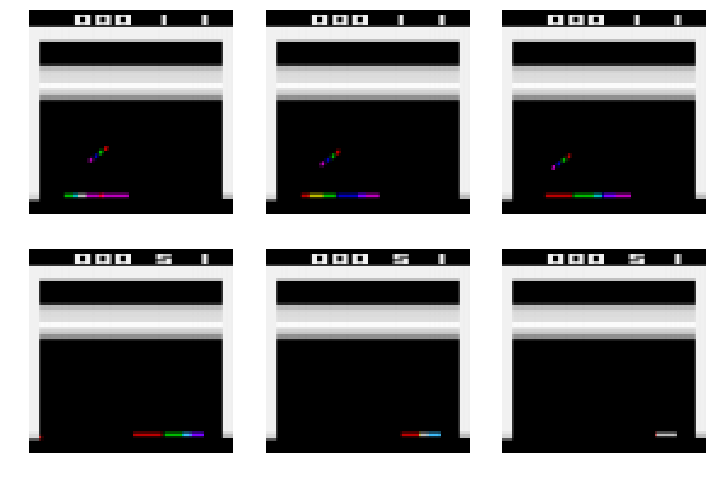

In [ ]:
plt.figure(figsize=(10, 6.8))
for row in range(2):
    for col in range(3):
        plt.subplot(2, 3, row * 3 + col + 1)
        plot_observation(trajectories.observation[row, col].numpy())
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0.02)
save_fig("sub_episodes_plot")
plt.show()

Now let's create the dataset:

In [ ]:
dataset = replay_buffer.as_dataset(
    sample_batch_size=64,
    num_steps=2,
    num_parallel_calls=3).prefetch(3)

Convert the main functions to TF Functions for better performance:

In [ ]:
from tf_agents.utils.common import function

collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)

And now we are ready to run the main loop!

In [ ]:
def train_agent(n_iterations):
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(tf_env.batch_size)
    iterator = iter(dataset)
    for iteration in range(n_iterations):
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        train_loss = agent.train(trajectories)
        print("\r{} loss:{:.5f}".format(
            iteration, train_loss.loss.numpy()), end="")
        if iteration % 1000 == 0:
            log_metrics(train_metrics)

Run the next cell to train the agent for 10,000 steps. Then look at its behavior by running the following cell. You can run these two cells as many times as you wish. The agent will keep improving!

In [ ]:
train_agent(n_iterations=10000)

W0528 08:49:00.697262 140735810999168 deprecation.py:323] From /Users/ageron/miniconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/learning_rate_schedule.py:409: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
W0528 08:49:01.475340 140735810999168 deprecation.py:323] From /Users/ageron/miniconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1220: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
I0528 08:49:02.463025 140735810999168 metric_utils.py:47]  
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 4
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


997 loss:0.01551

I0528 08:50:16.405580 140735810999168 metric_utils.py:47]  
		 NumberOfEpisodes = 24
		 EnvironmentSteps = 4004
		 AverageReturn = 1.399999976158142
		 AverageEpisodeLength = 180.5


2000 loss:0.00024

I0528 08:51:28.353239 140735810999168 metric_utils.py:47]  
		 NumberOfEpisodes = 47
		 EnvironmentSteps = 8004
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 165.89999389648438


2997 loss:0.00010

I0528 08:52:36.316717 140735810999168 metric_utils.py:47]  
		 NumberOfEpisodes = 69
		 EnvironmentSteps = 12004
		 AverageReturn = 0.800000011920929
		 AverageEpisodeLength = 162.3000030517578


3999 loss:0.00751

I0528 08:53:47.764101 140735810999168 metric_utils.py:47]  
		 NumberOfEpisodes = 92
		 EnvironmentSteps = 16004
		 AverageReturn = 0.699999988079071
		 AverageEpisodeLength = 161.89999389648438


4997 loss:0.00032

I0528 08:54:57.040647 140735810999168 metric_utils.py:47]  
		 NumberOfEpisodes = 111
		 EnvironmentSteps = 20004
		 AverageReturn = 1.0
		 AverageEpisodeLength = 181.60000610351562


6000 loss:0.00006

I0528 08:56:07.210252 140735810999168 metric_utils.py:47]  
		 NumberOfEpisodes = 131
		 EnvironmentSteps = 24004
		 AverageReturn = 1.7000000476837158
		 AverageEpisodeLength = 206.39999389648438


6999 loss:0.00784

I0528 08:57:18.494511 140735810999168 metric_utils.py:47]  
		 NumberOfEpisodes = 154
		 EnvironmentSteps = 28004
		 AverageReturn = 1.100000023841858
		 AverageEpisodeLength = 182.6999969482422


7997 loss:0.00002

I0528 08:58:35.320452 140735810999168 metric_utils.py:47]  
		 NumberOfEpisodes = 175
		 EnvironmentSteps = 32004
		 AverageReturn = 1.7999999523162842
		 AverageEpisodeLength = 196.60000610351562


8997 loss:0.00749

I0528 08:59:51.332596 140735810999168 metric_utils.py:47]  
		 NumberOfEpisodes = 195
		 EnvironmentSteps = 36004
		 AverageReturn = 1.100000023841858
		 AverageEpisodeLength = 185.8000030517578


9999 loss:0.00001

In [ ]:
frames = []
def save_frames(trajectory):
    global frames
    frames.append(tf_env.pyenv.envs[0].render(mode="rgb_array"))

prev_lives = tf_env.pyenv.envs[0].ale.lives()
def reset_and_fire_on_life_lost(trajectory):
    global prev_lives
    lives = tf_env.pyenv.envs[0].ale.lives()
    if prev_lives != lives:
        tf_env.reset()
        tf_env.pyenv.envs[0].step(1)
        prev_lives = lives

watch_driver = DynamicStepDriver(
    tf_env,
    agent.policy,
    observers=[save_frames, reset_and_fire_on_life_lost, ShowProgress(1000)],
    num_steps=1000)
final_time_step, final_policy_state = watch_driver.run()

plot_animation(frames)

If you want to save an animated GIF to show off your agent to your friends, here's one way to do it:

In [ ]:
import PIL

image_path = os.path.join("images", "rl", "breakout.gif")
frame_images = [PIL.Image.fromarray(frame) for frame in frames[:150]]
frame_images[0].save(image_path, format='GIF',
                     append_images=frame_images[1:],
                     save_all=True,
                     duration=30,
                     loop=0)

In [ ]:
%%html
<img src="images/rl/breakout.gif" />

# Extra material

## Deque vs Rotating List

The `deque` class offers fast append, but fairly slow random access (for large replay memories):

In [ ]:
from collections import deque
np.random.seed(42)

mem = deque(maxlen=1000000)
for i in range(1000000):
    mem.append(i)
[mem[i] for i in np.random.randint(1000000, size=5)]

[121958, 671155, 131932, 365838, 259178]

In [ ]:
%timeit mem.append(1)

76.8 ns ± 0.31 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [ ]:
%timeit [mem[i] for i in np.random.randint(1000000, size=5)]

320 µs ± 23 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Alternatively, you could use a rotating list like this `ReplayMemory` class. This would make random access faster for large replay memories:

In [ ]:
class ReplayMemory:
    def __init__(self, max_size):
        self.buffer = np.empty(max_size, dtype=np.object)
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = np.random.randint(self.size, size=batch_size)
        return self.buffer[indices]

In [ ]:
mem = ReplayMemory(max_size=1000000)
for i in range(1000000):
    mem.append(i)
mem.sample(5)

array([757386, 904203, 190588, 595754, 865356], dtype=object)

In [ ]:
%timeit mem.append(1)

761 ns ± 17.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [ ]:
%timeit mem.sample(5)

2.97 µs ± 16.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## Creating a Custom TF-Agents Environment

To create a custom TF-Agent environment, you just need to write a class that inherits from the `PyEnvironment` class and implements a few methods. For example, the following minimal environment represents a simple 4x4 grid. The agent starts in one corner (0,0) and must move to the opposite corner (3,3). The episode is done if the agent reaches the goal (it gets a +10 reward) or if the agent goes out of bounds (-1 reward). The actions are up (0), down (1), left (2) and right (3).

In [ ]:
class MyEnvironment(tf_agents.environments.py_environment.PyEnvironment):
    def __init__(self, discount=1.0):
        super().__init__()
        self._action_spec = tf_agents.specs.BoundedArraySpec(
            shape=(), dtype=np.int32, name="action", minimum=0, maximum=3)
        self._observation_spec = tf_agents.specs.BoundedArraySpec(
            shape=(4, 4), dtype=np.int32, name="observation", minimum=0, maximum=1)
        self.discount = discount

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self._state = np.zeros(2, dtype=np.int32)
        obs = np.zeros((4, 4), dtype=np.int32)
        obs[self._state[0], self._state[1]] = 1
        return tf_agents.trajectories.time_step.restart(obs)

    def _step(self, action):
        self._state += [(-1, 0), (+1, 0), (0, -1), (0, +1)][action]
        reward = 0
        obs = np.zeros((4, 4), dtype=np.int32)
        done = (self._state.min() < 0 or self._state.max() > 3)
        if not done:
            obs[self._state[0], self._state[1]] = 1
        if done or np.all(self._state == np.array([3, 3])):
            reward = -1 if done else +10
            return tf_agents.trajectories.time_step.termination(obs, reward)
        else:
            return tf_agents.trajectories.time_step.transition(obs, reward,
                                                               self.discount)

The action and observation specs will generally be instances of the `ArraySpec` or `BoundedArraySpec` classes from the `tf_agents.specs` package (check out the other specs in this package as well). Optionally, you can also define a `render()` method, a `close()` method to free resources, as well as a `time_step_spec()` method if you don't want the `reward` and `discount` to be 32-bit float scalars. Note that the base class takes care of keeping track of the current time step, which is why we must implement `_reset()` and `_step()` rather than `reset()` and `step()`.


In [ ]:
my_env = MyEnvironment()
time_step = my_env.reset()
time_step

TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[1, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=int32))

In [ ]:
time_step = my_env.step(1)
time_step

TimeStep(step_type=array(1, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[0, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=int32))